# Day 3 作业--Pixel2Pixel：人像卡通化

经过今天的学习，相信大家对图像翻译、风格迁移有了一定的了解啦，是不是也想自己动手来实现下呢？

那么，为了满足大家动手实践的愿望，同时为了巩固大家学到的知识，我们Day 3的作业便是带大家完成一遍课程讲解过的应用--**Pixel2Pixel：人像卡通化**

在本次作业中，大家需要做的是：**补齐代码，跑通训练，提交一张卡通化的成品图，动手完成自己的第一个人像卡通化的应用~**

![](https://ai-studio-static-online.cdn.bcebos.com/6e3af14bf9f847ab92215753fb3b8f61a66186b538f44da78ca56627c35717b8)

## 准备工作：引入依赖 & 数据准备

In [1]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


### 数据准备：

- 真人数据来自[seeprettyface](http://www.seeprettyface.com/mydataset.html)。
- 数据预处理（详情见[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目）。
<div>
  <img src='https://ai-studio-static-online.cdn.bcebos.com/c56c889827534363a8b6909d7737a1da64635ad33e1e44cb822f4c1cf1dfc689' height='1000px' width='1000px'>
</div>

- 使用[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目生成真人数据对应的卡通数据。

In [ ]:
# 解压数据
!unzip -oq data/data79149/cartoon_A2B.zip -d data/

### 数据可视化

训练集数据量: 1361
测试集数据量: 100
(256, 512, 3)
(256, 512, 3)
(256, 512, 3)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


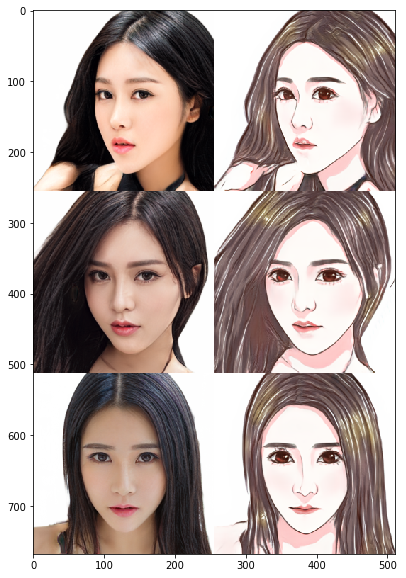

In [2]:
# 训练数据统计
train_names = os.listdir('data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 3, replace=False):
    img = cv2.imread('data/cartoon_A2B/train/'+img_name)
    imgs.append(img)
    print(img.shape)

img_show = np.vstack(imgs)[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

In [3]:
class PairedData(Dataset):
    def __init__(self, phase):
        super(PairedData, self).__init__() 
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 数据量

    def __getitem__(self, idx):
        img_A2B = cv2.imread(self.img_path_list[idx])     # 读取数据
        img_A2B = img_A2B.astype('float32') / 127.5 - 1.  # 归一化
        img_A2B = img_A2B.transpose(2, 0, 1)              # HWC -> CHW
        img_A = img_A2B[..., :256]                        # 真人照
        img_B = img_A2B[..., 256:]                        # 卡通图
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = 'data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]

In [4]:
paired_dataset_train = PairedData('train')
paired_dataset_test = PairedData('test')

## 第一步：搭建生成器

### 请大家补齐空白处的代码，‘#’ 后是提示。

原始代码输出模型尺寸打印：

![](https://ai-studio-static-online.cdn.bcebos.com/ca5008e8d9644ab8afe38fe9ba6d493b120e679151a1477384b4a779c027d98c)


In [5]:
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        # print(d1.shape)
        d2 = self.down2(d1)
        # print(d2.shape)
        d3 = self.down3(d2)
        # print(d3.shape)
        d4 = self.down4(d3)
        # print(d4.shape)
        d5 = self.down5(d4)
        # print(d5.shape)
        d6 = self.down6(d5)
        # print(d6.shape)
        d7 = self.down7(d6)
        # print(d7.shape)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        # print(x.shape)
        x = self.up6(x, d6)
        # print(x.shape)
        x = self.up5(x, d5)
        # print(x.shape)
        x = self.up4(x, d4)
        # print(x.shape)
        x = self.up3(x, d3)
        # print(x.shape)
        x = self.up2(x, d2)
        # print(x.shape)
        x = self.up1(x, d1)
        # print(x.shape)

        x = self.output_block(x)
        return x


class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
            # LeakyReLU, leaky=0.2
            # Conv2D
            # BatchNorm2D
            nn.LeakyReLU(0.2),
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            nn.BatchNorm2D(out_dim)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            # ReLU
            # Conv2DTranspose
            # nn.BatchNorm2D
            nn.ReLU(),
            # (o - k + 2 * p) / s + 1 = i -> o = (i-1) * s + k - 2 * p  
            # -> o = (i-1) * 2 + 4 - 2 * 1 = 2*i
            nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding), 
            nn.BatchNorm2D(out_dim)
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

## 第二步：鉴别器的搭建

### 请大家补齐空白处的代码，‘#’ 后是提示。

In [6]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            # (B, 6, 256, 256)
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            # (B, 64, 128, 128)
            # add BN
            nn.BatchNorm2D(ndf),
            nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            # (B, 128, 64, 64)
            ConvBlock(ndf*2, ndf*4),
            # (B, 256, 32, 32)
            # change kernel_size
            ConvBlock(ndf*4, ndf*8, kernel_size=3, stride=1),
            # (B, 512, 32, 32)

            nn.Conv2D(ndf*8, 1, kernel_size=3, stride=1, padding=1),
            # (B, 1, 32, 32)
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            # Conv2D
            # BatchNorm2D
            # LeakyReLU, leaky=0.2
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),  # (i - 4 + 2 * 1) / 2 + 1 = i / 2 
            nn.BatchNorm2D(out_dim),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [7]:
generator = UnetGenerator()
discriminator = NLayerDiscriminator()

In [8]:
out = generator(paddle.ones([1, 3, 256, 256]))
print('生成器输出尺寸：', out.shape)  # 应为[1, 3, 256, 256]

out = discriminator(paddle.ones([1, 6, 256, 256]))
print('鉴别器输出尺寸：', out.shape)  # 应为[1, 1, 30, 30]  改为 [1, 1, 32, 32]

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 32, 32]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


In [9]:
# 超参数
LR = 3e-4  # 1e-4
BATCH_SIZE = 64
EPOCHS = 100

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=generator.parameters(),
    beta1=0.9, # 0.5
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=discriminator.parameters(), 
    beta1=0.9, # 0.5
    beta2=0.999)
    
# 损失函数
bce_loss = nn.BCELoss()
# l1_loss = nn.L1Loss() 
# change to smoothL1
l1_loss = nn.SmoothL1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE
    )

In [10]:
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

for epoch in range(EPOCHS):
    for data in tqdm(data_loader_train):
        real_A, real_B = data
        
        optimizerD.clear_grad()
        # D([real_A, real_B])
        real_AB = paddle.concat((real_A, real_B), 1)  # N C H W 在C维度上拼接
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D([real_A, fake_B])
        fake_B = generator(real_A).detach()
        fake_AB = paddle.concat((real_A, fake_B), 1)  # N C H W 在C维度上拼接
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_fake_predict))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D([real_A, fake_B])
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A, fake_B), 1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones_like(g_fake_predict))
        g_l1_loss = l1_loss(fake_B, real_B) * 100.
        g_loss = g_bce_loss + g_l1_loss
        
        # train G
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)

        # cv2.imshow(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [1/100] Loss D: [0.64139545], Loss G: [5.0024576]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [2/100] Loss D: [0.6188241], Loss G: [4.0147886]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [3/100] Loss D: [0.6013614], Loss G: [3.5728245]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [4/100] Loss D: [0.6295968], Loss G: [3.4238238]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [5/100] Loss D: [0.6603869], Loss G: [3.1607265]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [6/100] Loss D: [0.6846347], Loss G: [2.9835365]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [7/100] Loss D: [0.6879256], Loss G: [2.9028177]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [8/100] Loss D: [0.6642017], Loss G: [2.7477844]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [9/100] Loss D: [0.67047596], Loss G: [2.7624612]


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


Epoch [10/100] Loss D: [0.6618836], Loss G: [2.679487]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [11/100] Loss D: [0.6389437], Loss G: [2.5390763]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [12/100] Loss D: [0.6278712], Loss G: [2.4531572]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [13/100] Loss D: [0.69659334], Loss G: [2.7149339]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [14/100] Loss D: [0.6596075], Loss G: [2.52572]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [15/100] Loss D: [0.6130401], Loss G: [2.4790177]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [16/100] Loss D: [0.66085887], Loss G: [2.3914871]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [17/100] Loss D: [0.68674374], Loss G: [2.4971757]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [18/100] Loss D: [0.6458522], Loss G: [2.338263]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [19/100] Loss D: [0.65551245], Loss G: [2.2772996]


100%|██████████| 21/21 [00:15<00:00,  1.40it/s]


Epoch [20/100] Loss D: [0.64924395], Loss G: [2.3279095]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [21/100] Loss D: [0.66315675], Loss G: [2.3009083]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [22/100] Loss D: [0.66828424], Loss G: [2.2706976]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [23/100] Loss D: [0.66019773], Loss G: [2.1498103]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [24/100] Loss D: [0.67378145], Loss G: [2.2231326]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [25/100] Loss D: [0.66946816], Loss G: [2.0957637]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [26/100] Loss D: [0.6692716], Loss G: [2.1904244]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [27/100] Loss D: [0.67062664], Loss G: [2.1353755]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [28/100] Loss D: [0.7052809], Loss G: [2.1006174]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [29/100] Loss D: [0.6691599], Loss G: [1.9753481]


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


Epoch [30/100] Loss D: [0.6880326], Loss G: [1.9795628]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [31/100] Loss D: [0.66751826], Loss G: [1.9011109]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [32/100] Loss D: [0.6771232], Loss G: [1.9217627]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [33/100] Loss D: [0.67447823], Loss G: [1.8700538]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [34/100] Loss D: [0.6813557], Loss G: [1.8413825]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [35/100] Loss D: [0.70116985], Loss G: [1.8201436]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [36/100] Loss D: [0.69130206], Loss G: [1.8336751]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [37/100] Loss D: [0.68571293], Loss G: [1.7797091]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [38/100] Loss D: [0.6924941], Loss G: [1.7511737]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [39/100] Loss D: [0.6989662], Loss G: [1.6734713]


100%|██████████| 21/21 [00:15<00:00,  1.40it/s]


Epoch [40/100] Loss D: [0.6697488], Loss G: [1.6757374]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [41/100] Loss D: [0.7008697], Loss G: [1.6950536]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [42/100] Loss D: [0.6990662], Loss G: [1.6019015]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [43/100] Loss D: [0.6737075], Loss G: [1.6019117]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [44/100] Loss D: [0.6825099], Loss G: [1.5837417]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [45/100] Loss D: [0.70245826], Loss G: [1.5466976]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [46/100] Loss D: [0.6832001], Loss G: [1.5252699]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [47/100] Loss D: [0.6933694], Loss G: [1.4839816]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [48/100] Loss D: [0.69914496], Loss G: [1.5347838]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [49/100] Loss D: [0.68937385], Loss G: [1.5141929]


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


Epoch [50/100] Loss D: [0.681741], Loss G: [1.4603966]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [51/100] Loss D: [0.6953299], Loss G: [1.4646199]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [52/100] Loss D: [0.6935219], Loss G: [1.4486811]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [53/100] Loss D: [0.68738115], Loss G: [1.4000381]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [54/100] Loss D: [0.68837166], Loss G: [1.3744817]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [55/100] Loss D: [0.6894889], Loss G: [1.3738935]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [56/100] Loss D: [0.6885167], Loss G: [1.3490039]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [57/100] Loss D: [0.6888608], Loss G: [1.3498154]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [58/100] Loss D: [0.6882838], Loss G: [1.309747]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [59/100] Loss D: [0.6868441], Loss G: [1.3152173]


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


Epoch [60/100] Loss D: [0.6954946], Loss G: [1.3119011]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [61/100] Loss D: [0.6882312], Loss G: [1.3058904]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [62/100] Loss D: [0.6935247], Loss G: [1.2816675]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [63/100] Loss D: [0.69643235], Loss G: [1.2690272]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [64/100] Loss D: [0.69619685], Loss G: [1.2420936]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [65/100] Loss D: [0.68671525], Loss G: [1.2237759]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [66/100] Loss D: [0.6869488], Loss G: [1.221802]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [67/100] Loss D: [0.6904741], Loss G: [1.2431719]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [68/100] Loss D: [0.69692516], Loss G: [1.2361054]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [69/100] Loss D: [0.6905943], Loss G: [1.1902776]


100%|██████████| 21/21 [00:14<00:00,  1.42it/s]


Epoch [70/100] Loss D: [0.69031405], Loss G: [1.2082542]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [71/100] Loss D: [0.70400476], Loss G: [1.2078283]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [72/100] Loss D: [0.68746215], Loss G: [1.1736245]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [73/100] Loss D: [0.69036627], Loss G: [1.166806]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [74/100] Loss D: [0.68264353], Loss G: [1.1729467]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [75/100] Loss D: [0.7005383], Loss G: [1.1613718]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [76/100] Loss D: [0.6963088], Loss G: [1.1564333]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [77/100] Loss D: [0.68802583], Loss G: [1.1672423]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [78/100] Loss D: [0.69977224], Loss G: [1.1519146]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [79/100] Loss D: [0.69522864], Loss G: [1.1548624]


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


Epoch [80/100] Loss D: [0.6886213], Loss G: [1.1312087]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [81/100] Loss D: [0.68821496], Loss G: [1.128866]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [82/100] Loss D: [0.69043905], Loss G: [1.13242]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [83/100] Loss D: [0.69522166], Loss G: [1.0927957]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [84/100] Loss D: [0.6908225], Loss G: [1.0904036]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [85/100] Loss D: [0.68857026], Loss G: [1.0964366]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [86/100] Loss D: [0.695171], Loss G: [1.0923932]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [87/100] Loss D: [0.68446434], Loss G: [1.1010132]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [88/100] Loss D: [0.69561267], Loss G: [1.0933092]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [89/100] Loss D: [0.6945545], Loss G: [1.0835338]


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


Epoch [90/100] Loss D: [0.6925413], Loss G: [1.0616744]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [91/100] Loss D: [0.69101286], Loss G: [1.076333]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [92/100] Loss D: [0.6911565], Loss G: [1.0466876]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [93/100] Loss D: [0.69198316], Loss G: [1.048883]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [94/100] Loss D: [0.68816936], Loss G: [1.0400043]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [95/100] Loss D: [0.6926134], Loss G: [1.0324479]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [96/100] Loss D: [0.6968533], Loss G: [1.0412518]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [97/100] Loss D: [0.6912768], Loss G: [1.0427504]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [98/100] Loss D: [0.69365835], Loss G: [1.0593998]


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [99/100] Loss D: [0.6892846], Loss G: [1.0323898]


100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


Epoch [100/100] Loss D: [0.689608], Loss G: [1.0113596]


## 最后：用你补齐的代码试试卡通化的效果吧！

In [11]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])
print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()

加载权重: work/weights/epoch100.pdparams


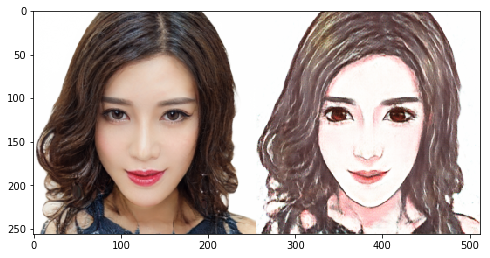

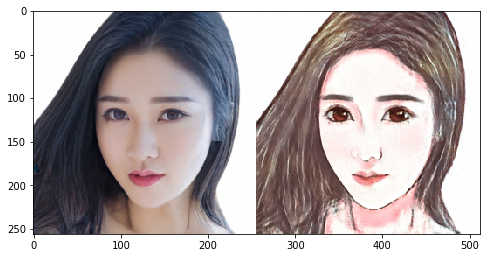

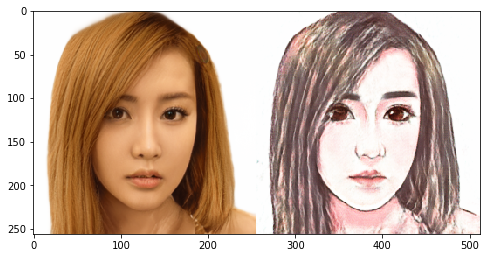

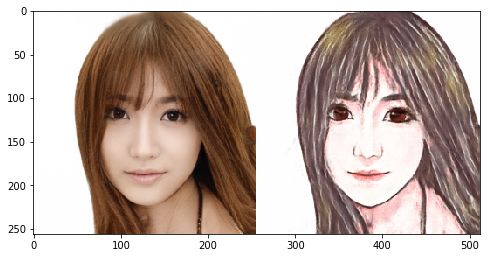

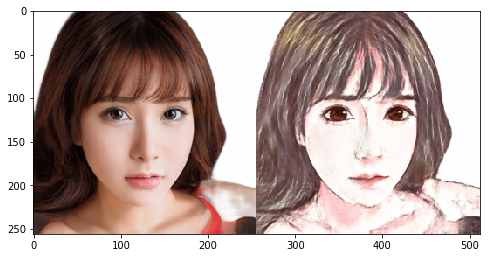

In [18]:
# 读取数据
test_names = os.listdir('data/cartoon_A2B/test')
for img_name in np.random.choice(test_names, 5, replace=False):
    img_A2B = cv2.imread('data/cartoon_A2B/test/'+img_name)
    img_A = img_A2B[:, :256]                                  # 真人照
    img_B = img_A2B[:, 256:]                                  # 卡通图

    g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
    g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
    g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

    g_output = generator(g_input)
    g_output = g_output.detach().numpy()                      # tensor -> numpy
    g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
    g_output = g_output * 127.5 + 127.5                       # 反归一化
    g_output = g_output.astype(np.uint8)

    img_show = np.hstack([img_A, g_output])[:,:,::-1]
    plt.figure(figsize=(8, 8))
    plt.imshow(img_show)
plt.show()